In [47]:
# Import libraries
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import pandas as pd

In [40]:
def load_data():
    data = pd.read_csv('digit-recognizer/train.csv')
    x = data.loc[:, data.columns != "label"]
    y = data['label']
    # Split train and test data
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)
    # Reshape data
    xtrain = xtrain.values.reshape((xtrain.shape[0], 28, 28, 1))
    xtest = xtest.values.reshape((xtest.shape[0], 28, 28, 1))
    ytrain = np.array(ytrain)
    ytest = np.array(ytest)
    # Normalize x
    xtrain_norm = xtrain.astype('float32') / 255.0
    xtest_norm = xtest.astype('float32') / 255.0
    # Make labels categorical
    ytrain = to_categorical(ytrain)
    ytest = to_categorical(ytest)
    return xtrain_norm, ytrain, xtest_norm, ytest

In [41]:
# Define CNN model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [42]:
# Evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# Prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# Enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# Define model
		model = define_model()
		# Select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# Fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# Evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# Store scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [43]:
# Plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# Plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# Plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [44]:
# Summarize model performance
def summarize_performance(scores):
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	plt.boxplot(scores)
	plt.show()

In [45]:
# Run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_data()
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

/Users/kprazuch/Documents/GitHub/MSCI546/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


> 98.229
> 98.065
> 98.214
> 98.378
> 98.244


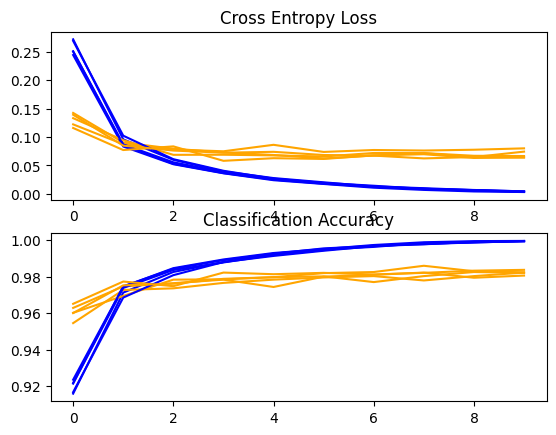

Accuracy: mean=98.226 std=0.099, n=5


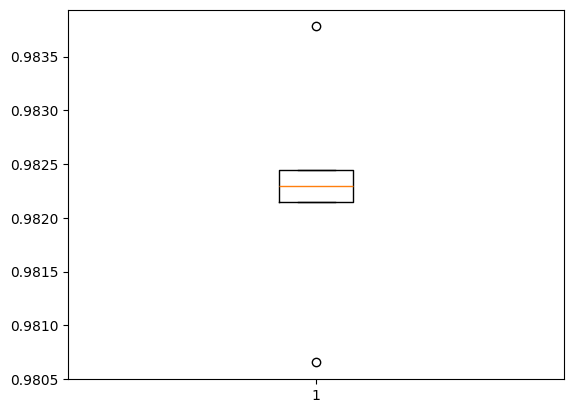

In [46]:
run_test_harness()